# Comparison of Gaussianness of Fastnoise Source and CLT-constructed XOROSHIRO128+-based source

## Intro

`gr::analog::fastnoise_source` is buggy, as it uses the non-reentrant `rand()` libc function. Oops!

I've taken this as motivation to quickly implement a really fast source, which I've based on [XOROSHIRO128+](http://vigna.di.unimi.it/xorshift/), which outperforms the common Mersenne Twister algorithms in terms of performance, and seemingly also statistics.

Because I was too lazy to port the [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) usually employed to convert discrete uniform to normally distributed, and also to prove a bit of a point: Here's the most naive way to get a normal variable:

Sum up $N$ summands, subtracting their mean and normalizing by their standard deviation times $\sqrt N$, and you get a $\mathcal N(0;1)$-distributed RV. The Central Limit Theorem for i.i.d. RVs: Great fun for the whole family!

## Imports

In [59]:
import numpy
from scipy import stats

from matplotlib import rc
try:
    rc("text", usetex = True)
except:
    pass

from matplotlib import pyplot
try:
    import seaborn
except:
    pass

import xoroshiro
from gnuradio import blocks, analog, gr

## Flow Graph Setup

In [60]:
tb = gr.top_block()


N_MIN = 5
N_MAX = 64
NUM_NS = 12
N_SAMPLES = 10**7
POOL_SIZES = [8192, 2**22, N_SAMPLES, N_SAMPLES * 10]

summands = numpy.linspace(N_MIN, N_MAX, NUM_NS, dtype=int)

fastnoise_srcs = [analog.fastnoise_source_f(analog.GR_GAUSSIAN, 1, 0, pool_size) for pool_size in POOL_SIZES]
# construct "a couple" of differently parameterized XOROSHIRO128p+ sources
sources = [xoroshiro.xoroshiro128p_source(seed=1, iterations=i) for i in summands] + fastnoise_srcs
heads = [blocks.head(nitems=N_SAMPLES, sizeof_stream_item=gr.sizeof_float) for _ in sources]
sinks = [blocks.vector_sink_f(vlen=1) for _ in heads]    
paths = zip(sources, heads, sinks)

for path in paths:
    tb.connect(*path)

## Letting things run

In [61]:
tb.run()

## Evaluating Data

(This might take a minute!)

In [62]:
kolmogorov_smirnov_stats = [stats.kstest(sink.data(), "norm")[0] for sink in sinks]

## Plotting Data

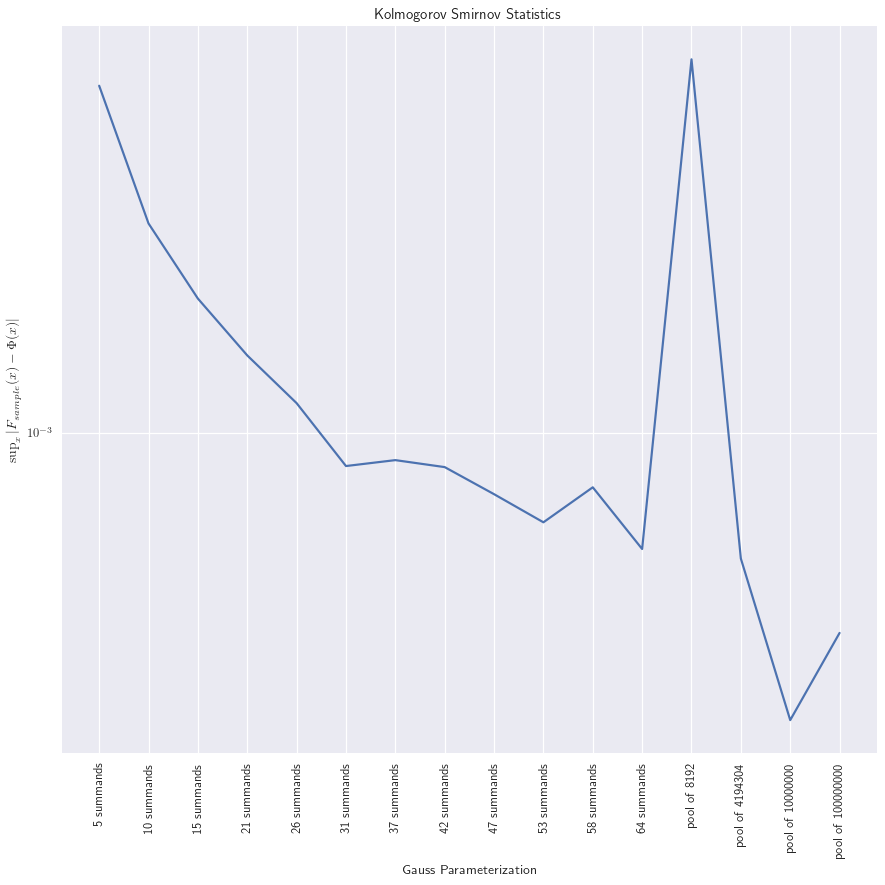

In [65]:
f = pyplot.figure(figsize=(10,10), dpi=90)
pyplot.title("Kolmogorov Smirnov Statistics")
pyplot.semilogy(kolmogorov_smirnov_stats)
xticks = ["{:d} summands".format(n) for n in summands] + ["pool of {:d}".format(pool_size) for pool_size in POOL_SIZES]
pyplot.xticks(range(len(sinks)), xticks, rotation = 90)
pyplot.xlabel("Gauss Parameterization")
pyplot.ylabel("$\sup_x |F_{sample}(x)-\Phi(x)|$")
pyplot.tight_layout()
pyplot.show()

## Conclusion

As one can see from above curve, even very small numbers of summands in a CLT-exploiting RNG outperforms a medium-sized pool for the fastnoise source.

Performance is clearly on the side of the online calculation of random numbers; only for $4\cdot 2^{22}$ Samples, i.e. 16MB of pool (which will clearly lead to high memory bandwidth, as fastnoise_source jumps rand()omly through that buffer), we end up with comparable performance as a 64-summand uniform-averaging generator. That's not very surprising as the pool is populated with "known to be well-distributed" numbers, and rand() isn't *that* bad, so that most numbers are only hit once in the $10^7$ samples we draw.

Autocorrelation tests are yet to be performed.

Just to give you a bit of a feeling about performance: on my AMD64 Phenom x2, clang 4.0.1, Linux 4.14.11

Size                 | MS/S
---------------------|-----------
**Fast Noise Source** pool size| –
$2^{13}$ |29.0
$2^{22}$ |9.0
$10^7$   |8.0
$10^8$   |6.8
**CLT XOROSHIRO128+** summands | –
5 | 38.4
10 |30.5
21 | 18.0
42 | 11.3
64 | 8.1

And that, by the way, does the summation without *any* effort to employ SIMD! Now, you'll say, SIMD for a summation is pretty irrelevant for a complicated thing such as an RNG, but there's really less than 20 instructions per generated integer, so naive order of mean subtraction and normalization does matter.